## Becnhamrking with standardized test cases

For benchmarking, we need a standardized set of case studies, ranging form simple to very large. This helps us to test and track the performance of improvements of bw_timex with the same set of test cases. This script defines the standardized these cases and then calculates some benchmarking results. [Results](#Plotting-the-results) are shown for two systems currently: 

- [Macbook Pro M4](#Results-Macbook-PRO-(2024)-Apple-M4-Pro-Chip)
- [Dell 11th Gen Intel Core i5 Windows 10](#Results-Dell-Windows-10-Enterprise)



The benchmarking tests for for the two different systems show that life cycle inventory step, in which the time explicit matrices get built and the linear system is solved, scales roughly linear with the total number of exchanges within the foreground (including from the foreground to the background). Of course, the resolution of the temporal distribution plays a role here as it determines "total number" of exchanges. We find that for a test system with up to 60 (random) processes in the foreground divided in two tiers, with 990 exchanges (960 in the foreground and 60 between foreground and background), each with a temporal resolution of 3 steps (990x3 virtual exchanges), the total calculation time on the varies drastically between the Windows Intel machine 1721±43s and the Mac ARM machine 186±0.5s. (mean and standard deviation of 3 runs). Going up to 5 steps in the temporal resolution of the exchanges, this increases to 250s on the Mac ARM machine (1 run). We find a slightly different behavior between the two machines, which can be likely be attributed to the chip architecture and the linear algebra solver. Where on the MAC ARM machine, the graph traversal takes about 40-50% of the total time, the Windows machine spends most time on the building of the matrices and database calls. We see that while the Mac is the faster machine in our case, the speed of the Intel linear algebra solver (py-) pardiso shines through in situations where large sparse systems need to be solved many times such as in the graph traversal phase. While for most systems the computation time should not be an issue, the speed performance of the bw_timex package remains a focus of further development steps. 

### 0) set up variables & functions

In [1]:
import numpy as np
import bw2data as bd

from bw_temporalis import TemporalDistribution
from datetime import datetime

from cProfile import Profile
from pstats import SortKey, Stats

import time
from bw_timex import TimexLCA


In [2]:
# Define the old and new project names
old_project_name = 'Reforrestation_Aforrestation'
new_project_name = 'timex_benchmarking'

# Restore the old project
if new_project_name not in bd.projects:
    import bw2io as bi
    import shutil
    bi.backup.restore_project_directory(fp= '/Users/ajakobs/Documents/Solene_Reforrestation_Aforrestation/brightway2-project-Reforrestation_Aforrestation-backup02-June-2025-05-23PM.tar.gz',
                                    overwrite_existing=True)


    # Set the current project to the old project
    bd.projects.set_current(old_project_name)

    # Get the project directory
    old_project_dir = bd.projects.dir

    # Create a new project
    bd.projects.set_current(new_project_name)

    # Get the new project directory
    new_project_dir = bd.projects.dir

    # Copy the old project directory to the new project directory
    shutil.copytree(old_project_dir, new_project_dir, dirs_exist_ok=True)

    print(f"Project loaded and copied to {new_project_name}.")
else:
    bd.projects.set_current(new_project_name)


In [3]:
list(bd.databases)

['ecoinvent-3.11-biosphere',
 'ecoinvent-3.11-cutoff',
 'ei_cutoff_3.11_image_SSP2-M_2020 2025-05-30',
 'ei_cutoff_3.11_image_SSP2-M_2030 2025-05-30',
 'ei_cutoff_3.11_image_SSP2-M_2040 2025-05-30',
 'ei_cutoff_3.11_image_SSP2-M_2050 2025-05-30']

In [4]:
# Remove all test systems from the project
def clear_test_systems():
    to_delete = []
    for db in bd.databases:  # deleting all test_systems
        if "test" in db:
            to_delete.append(db)
    print(to_delete)

    for db in to_delete:
        del bd.databases[db]

    print(bd.databases)

clear_test_systems()

[]
Databases dictionary with 6 object(s):
	ecoinvent-3.11-biosphere
	ecoinvent-3.11-cutoff
	ei_cutoff_3.11_image_SSP2-M_2020 2025-05-30
	ei_cutoff_3.11_image_SSP2-M_2030 2025-05-30
	ei_cutoff_3.11_image_SSP2-M_2040 2025-05-30
	ei_cutoff_3.11_image_SSP2-M_2050 2025-05-30


In [5]:
base_background_db = bd.Database("ei_cutoff_3.11_image_SSP2-M_2020 2025-05-30")

In [6]:
list_random_acts = []
for i in range(0, 100):
    act = base_background_db.random()
    list_random_acts.append((act["code"]))

In [7]:
fixed_random_acts = list_random_acts

In [8]:
def create_standardized_test_system(
    db_name,
    number_tiers,
    number_processes_per_tier,
    td_timesteps,
    td_dtype,
    fixed_random_acts,
    number_background_exchanges_per_process,
    base_background_db_name,
    loop=False,
):
    """
    Create a foreground database with a standardized structure for testing purposes. It contains number_tiers supply chain levels, with each containing
    number_processes_per_tier processes. Each process consumes from all processes in the tier below. At the last tier, each process consumes a certain numebr of background process
    Each process has a temporal distribution with td_timesteps steps, e.g. 3, in td_dtype resolution, e.g. years, starting at a unit of time later than the consuming process
    The last tier consumes a process from the background system in 2020, selecting a process from a predefined list of random processes, with the same temporal distribution as above.
    If loop = True, a loop is included: the last process in last tier consumes from the last process in first tier, no TDs at this node.
    No additional TDs at biosphere flows.

    Parameters:
    db_name: str, name of the database
    number_tiers: int, number of tiers in the supply chain
    number_processes_per_tier: int, number of processes per tier
    td_timesteps: int, number of timesteps in the temporal distribution
    td_dtype: str, dtype of the temporal distribution, e.g. "timedelta64[Y]" or "timedelta64[M]"
    fixed_random_acts: a list of 100 background activities codes that has been pre-generated
    number_background_exchanges_per_process: int, number of background exchanges per process in the last tier
    base_background_db_name: str, name of the background database to use for the last tier processes, e.g. "ei_cutoff_3.11_image_SSP2-M_2020 2025-05-30"
    loop: bool, whether to include a loop in the foreground system

    returns: None


    """

    # create a new database
    if db_name in bd.databases:
        del bd.databases[db_name]
        print(f"Database {db_name} already exists, overwriting.")
    foreground = bd.Database(db_name)
    foreground.register()

    background_db = bd.Database(
        base_background_db_name
    )  # background database for 2020 in timex project

    # save FU node
    FU_node = foreground.new_node(code="FU", name="functional unit", unit="unit")
    FU_node.save()
    FU_node.new_edge(input=FU_node, amount=1, unit="unit", type="production").save()

    # create nodes
    for tier in range(1, number_tiers + 1):
        for process in range(1, number_processes_per_tier + 1):
            process_name = f"tier{tier}_act{process}"
            process_code = f"t{tier}_a{process}"
            process_node = foreground.new_node(
                code=process_code, name=process_name, unit="unit"
            )
            process_node.save()
            process_node.new_edge(
                input=process_node, amount=1, unit="unit", type="production"
            ).save()

    # relink nodes
    for tier in range(1, number_tiers + 1):
        for process in range(1, number_processes_per_tier + 1):
            process_name = f"tier{tier}_act{process}"
            process_code = f"t{tier}_a{process}"
            process_node = foreground.get(process_code)
            if tier == 1:  # tier 1 = FU
                consuming_node = FU_node
                new_edge = consuming_node.new_edge(
                    input=process_node, amount=1, unit="unit", type="technosphere"
                )
                new_edge.save()
            else:  # lower tiers: all nodes at the tier above consume from all nodes at the tier below, with a temporal distribution specified by the inputs
                for process in range(1, number_processes_per_tier + 1):
                    consuming_node = foreground.get(f"t{tier-1}_a{process}")
                    new_edge = consuming_node.new_edge(
                        input=process_node, amount=1, unit="unit", type="technosphere"
                    )
                    temporal_distribution = TemporalDistribution(
                        date=np.array(np.arange(1, td_timesteps + 1), dtype=td_dtype),
                        amount=np.full(td_timesteps, 1 / td_timesteps),
                    )  # linear distribution between 1 and td_timesteps in years
                    new_edge["temporal_distribution"] = temporal_distribution
                    new_edge.save()

    # add background process to nodes on last tier
    count_background_act = 0  # counting upward in list of random acts
    total_background_count = 0
    for process in range(1, number_processes_per_tier + 1):
        last_foreground_node = foreground.get(f"t{number_tiers}_a{process}")

        for _ in range(1, number_background_exchanges_per_process + 1):
            background_process = background_db.get(
                code=fixed_random_acts[count_background_act]
            )
            count_background_act += 1

            new_edge = last_foreground_node.new_edge(
                input=background_process, amount=4, type="technosphere"
            )
            temporal_distribution = TemporalDistribution(
                date=np.array(np.arange(1, td_timesteps + 1), dtype=td_dtype),
                amount=np.full(td_timesteps, 1 / td_timesteps),
            )  # linear distribution between 1 and td_timesteps in years
            new_edge["temporal_distribution"] = temporal_distribution
            new_edge.save()

            if (
                count_background_act == 99
            ):  # if all 100 background processes have been used, start again
                total_background_count += count_background_act
                count_background_act = 0

    if loop:
        # add loop to foreground: last process in last tier consumes from last process in first tier, no TDs
        loop_consumer = foreground.get(f"t{number_tiers}_a{number_processes_per_tier}")
        loop_producer = foreground.get(f"t{1}_a{number_processes_per_tier}")
        new_edge = loop_consumer.new_edge(
            input=loop_producer, amount=0.3, type="technosphere"
        )
        new_edge.save()

    count_exc = 0
    for act in foreground:
        for exc in act.technosphere():
            count_exc += 1

    total_background_count += (
        count_background_act  # number of background processes used in total
    )

    print(
        f"Database {db_name} created with {len(foreground)} processes and {count_exc} exchanges. There are {total_background_count} different background processes used."
    )
    return len(foreground), count_exc, total_background_count

### 1) small system

In [9]:
def _database_dates(db_name):
    database_dates = {
    "ei_cutoff_3.11_image_SSP2-M_2020 2025-05-30": datetime.strptime("2020", "%Y"),
    "ei_cutoff_3.11_image_SSP2-M_2030 2025-05-30": datetime.strptime("2030", "%Y"),
    "ei_cutoff_3.11_image_SSP2-M_2040 2025-05-30": datetime.strptime("2040", "%Y"),
    "ei_cutoff_3.11_image_SSP2-M_2050 2025-05-30": datetime.strptime("2050", "%Y"),
    db_name: "dynamic",
    }
    return database_dates

In [10]:
# set method
method = ('ecoinvent-3.11', 'IPCC 2021 (incl. biogenic CO2)', 'climate change: total (incl. biogenic CO2)', 'global warming potential (GWP100)')

In [66]:
# Clear any existing test systems in the project
clear_test_systems()

n_processes = np.array([1,2,3,5,10,15,20,25,30])
n_tiers = np.array([1,2])
time_steps = 5
N_repeats = 1  # number of repeats for each test to get averages

time_initialize = []
time_build_timeline = []
time_lci = []
time_lcia = []
time_total = []

# Create foreground databases with different numbers of processes and tiers
test_db_names = []
n_foreground = []
n_exchanges = []
n_background = []
nr_processes = []
nr_tiers = []

for n_tier in n_tiers[:]:
    for n_process in n_processes[:]:
        # repeat to get averages
        for repeat in range(N_repeats):
            print(f"Repeat {repeat + 1}/{N_repeats} for {n_tier} tiers and {n_process} processes...")
            nr_processes.append(n_process)
            nr_tiers.append(n_tier)
            # Create a unique database name based on the number of tiers and processes
            db_name = f"test_{n_tier}tiers_{n_process}processes"
            database_dates = _database_dates(db_name)
            test_db_names.append(db_name)
            # print(f"Processing database {db_name} with {n_tier} tiers and {n_process} processes per tier...")
            # Check if the database already exists
            if db_name not in bd.databases:
                # Create the standardized test system
                # print(f"Creating database {db_name}...")
                db_name = f"test_{n_tier}tiers_{n_process}processes"
                n_fg, n_exch, n_bg = create_standardized_test_system(db_name=db_name,
                                                number_tiers=n_tier,
                                                number_processes_per_tier=n_process,
                                                td_timesteps=time_steps,
                                                td_dtype="timedelta64[Y]",
                                                fixed_random_acts=fixed_random_acts,
                                                number_background_exchanges_per_process=2,
                                                base_background_db_name="ei_cutoff_3.11_image_SSP2-M_2020 2025-05-30",
                                                loop=False)
                n_foreground.append(n_fg)
                n_exchanges.append(n_exch)
                n_background.append(n_bg)
            
            # Process each database
            print(f"benchmarking database {db_name}...")
            # set funcitonal unit
            FU_node = bd.Database(db_name).get("FU")
            #initialize the TimexLCA object
            t0 = time.time()
            tlca = TimexLCA(demand={FU_node: 1},
            method=method,
            database_dates=database_dates,
            )
            t1 = time.time()
            time_initialize.append(t1 - t0)
            # build the timeline
            t2 = time.time()
            tlca.build_timeline()
            t3 = time.time()
            time_build_timeline.append(t3 - t2)
            # run the LCI
            t4 = time.time()
            tlca.lci()
            t5 = time.time()
            time_lci.append(t5 - t4)
            # run the LCIA
            t6 = time.time()
            tlca.static_lcia()
            t7 = time.time()
            time_lcia.append(t7 - t6)
            time_total.append(t7 - t0)
            # print(f"{time.ctime()}: Database {db_name} processed in {t7 - t0:.2f} seconds.")
            # print("deleting test db from project...")
            del bd.databases[db_name]

[]
Databases dictionary with 6 object(s):
	ecoinvent-3.11-biosphere
	ecoinvent-3.11-cutoff
	ei_cutoff_3.11_image_SSP2-M_2020 2025-05-30
	ei_cutoff_3.11_image_SSP2-M_2030 2025-05-30
	ei_cutoff_3.11_image_SSP2-M_2040 2025-05-30
	ei_cutoff_3.11_image_SSP2-M_2050 2025-05-30
Repeat 1/1 for 1 tiers and 1 processes...
Database test_1tiers_1processes created with 2 processes and 3 exchanges. There are 2 different background processes used.
benchmarking database test_1tiers_1processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-20 10:16:59.134 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 3


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/1 for 1 tiers and 2 processes...
Database test_1tiers_2processes created with 3 processes and 6 exchanges. There are 4 different background processes used.
benchmarking database test_1tiers_2processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-20 10:17:17.363 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 5


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/1 for 1 tiers and 3 processes...
Database test_1tiers_3processes created with 4 processes and 9 exchanges. There are 6 different background processes used.
benchmarking database test_1tiers_3processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-20 10:17:39.502 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 7


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/1 for 1 tiers and 5 processes...
Database test_1tiers_5processes created with 6 processes and 15 exchanges. There are 10 different background processes used.
benchmarking database test_1tiers_5processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-20 10:18:06.333 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 10


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/1 for 1 tiers and 10 processes...
Database test_1tiers_10processes created with 11 processes and 30 exchanges. There are 20 different background processes used.
benchmarking database test_1tiers_10processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-20 10:18:38.922 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 21


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/1 for 1 tiers and 15 processes...
Database test_1tiers_15processes created with 16 processes and 45 exchanges. There are 30 different background processes used.
benchmarking database test_1tiers_15processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-20 10:19:30.115 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 26


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/1 for 1 tiers and 20 processes...
Database test_1tiers_20processes created with 21 processes and 60 exchanges. There are 40 different background processes used.
benchmarking database test_1tiers_20processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-20 10:20:35.191 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 38


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/1 for 1 tiers and 25 processes...
Database test_1tiers_25processes created with 26 processes and 75 exchanges. There are 50 different background processes used.
benchmarking database test_1tiers_25processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-20 10:21:58.505 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 50


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/1 for 1 tiers and 30 processes...
Database test_1tiers_30processes created with 31 processes and 90 exchanges. There are 60 different background processes used.
benchmarking database test_1tiers_30processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-20 10:23:44.388 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 62


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/1 for 2 tiers and 1 processes...
Database test_2tiers_1processes created with 3 processes and 4 exchanges. There are 2 different background processes used.
benchmarking database test_2tiers_1processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-20 10:25:52.186 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 4


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/1 for 2 tiers and 2 processes...
Database test_2tiers_2processes created with 5 processes and 10 exchanges. There are 4 different background processes used.
benchmarking database test_2tiers_2processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-20 10:26:14.047 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 12


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/1 for 2 tiers and 3 processes...
Database test_2tiers_3processes created with 7 processes and 18 exchanges. There are 6 different background processes used.
benchmarking database test_2tiers_3processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-20 10:26:42.319 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 18


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/1 for 2 tiers and 5 processes...
Database test_2tiers_5processes created with 11 processes and 40 exchanges. There are 10 different background processes used.
benchmarking database test_2tiers_5processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-20 10:27:14.683 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 45


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/1 for 2 tiers and 10 processes...
Database test_2tiers_10processes created with 21 processes and 130 exchanges. There are 20 different background processes used.
benchmarking database test_2tiers_10processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-20 10:28:00.971 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 150


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/1 for 2 tiers and 15 processes...
Database test_2tiers_15processes created with 31 processes and 270 exchanges. There are 30 different background processes used.
benchmarking database test_2tiers_15processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-20 10:29:30.387 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 270


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/1 for 2 tiers and 20 processes...
Database test_2tiers_20processes created with 41 processes and 460 exchanges. There are 40 different background processes used.
benchmarking database test_2tiers_20processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-20 10:31:41.234 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 360


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/1 for 2 tiers and 25 processes...
Database test_2tiers_25processes created with 51 processes and 700 exchanges. There are 50 different background processes used.
benchmarking database test_2tiers_25processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-20 10:34:17.623 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 475


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/1 for 2 tiers and 30 processes...
Database test_2tiers_30processes created with 61 processes and 990 exchanges. There are 60 different background processes used.
benchmarking database test_2tiers_30processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-20 10:37:33.733 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 630


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


In [67]:
len_processes = len(n_processes)
len_tiers = len(n_tiers)
# Reshape the results
time_initialize = np.asarray(time_initialize).reshape(len_tiers, len_processes, N_repeats)
time_build_timeline = np.asarray(time_build_timeline).reshape(len_tiers, len_processes, N_repeats)
time_lci = np.asarray(time_lci).reshape(len_tiers, len_processes, N_repeats)
time_lcia = np.asarray(time_lcia).reshape(len_tiers, len_processes, N_repeats)
time_total = np.asarray(time_total).reshape(len_tiers, len_processes, N_repeats)
nr_processes = np.asarray(nr_processes).reshape(len_tiers, len_processes, N_repeats)
nr_tiers = np.asarray(nr_tiers).reshape(len_tiers, len_processes, N_repeats)
n_foreground = np.asarray(n_foreground).reshape(len_tiers, len_processes, N_repeats)
n_exchanges = np.asarray(n_exchanges).reshape(len_tiers, len_processes, N_repeats)
n_background = np.asarray(n_background).reshape(len_tiers, len_processes, N_repeats)

In [22]:
# option to save results

import os

# Ensure the save_path directory exists
save_path = "/Users/ajakobs/Documents/prospective_dynamic_lca/timex_benchmarking_results_arthur" # change to your name

os.makedirs(save_path, exist_ok=True)

# List of arrays to save
arrays_to_save = [
    'time_initialize', 'time_build_timeline', 'time_lci', 'time_lcia', 'time_total',
    'nr_processes', 'nr_tiers', 'n_foreground', 'n_exchanges', 'n_background'
]


In [24]:
# Save each array to a .npy file
for arr_name in arrays_to_save:
    arr = globals()[arr_name]
    np.save(os.path.join(save_path, f"{arr_name}.npy"), arr)

In [15]:
for i,tier in enumerate(n_tiers[:]):
    for j,process in enumerate(n_processes[:]):
        db_name = f"test_{tier}tiers_{process}processes"
        print(f"Database {db_name} total time: {time_total[i,j,:].mean():.2f} +/- {time_total[i,j,:].std():.2f} seconds.")
        print(f"Time to initialize: {time_initialize[i,j,:].mean():.2f} +/- {time_initialize[i,j,:].std():.2f} seconds.")
        print(f"Time to build timeline: {time_build_timeline[i,j,:].mean():.2f} +/- {time_build_timeline[i,j,:].std():.2f} seconds.")
        print(f"Time to run LCI: {time_lci[i,j,:].mean():.2f} +/- {time_lci[i,j,:].std():.2f} seconds.")
        print(f"Time to run LCIA: {time_lcia[i,j,:].mean():.2f} +/- {time_lcia[i,j,:].std():.2f} seconds.")

Database test_1tiers_1processes total time: 17.88 +/- 0.19 seconds.
Time to initialize: 4.83 +/- 0.12 seconds.
Time to build timeline: 7.33 +/- 0.15 seconds.
Time to run LCI: 5.73 +/- 0.07 seconds.
Time to run LCIA: 0.00 +/- 0.00 seconds.
Database test_1tiers_2processes total time: 21.99 +/- 0.35 seconds.
Time to initialize: 4.99 +/- 0.07 seconds.
Time to build timeline: 11.03 +/- 0.15 seconds.
Time to run LCI: 5.97 +/- 0.27 seconds.
Time to run LCIA: 0.00 +/- 0.00 seconds.
Database test_1tiers_3processes total time: 25.94 +/- 0.32 seconds.
Time to initialize: 5.01 +/- 0.06 seconds.
Time to build timeline: 14.37 +/- 0.15 seconds.
Time to run LCI: 6.56 +/- 0.23 seconds.
Time to run LCIA: 0.00 +/- 0.00 seconds.
Database test_1tiers_5processes total time: 31.37 +/- 0.49 seconds.
Time to initialize: 5.10 +/- 0.18 seconds.
Time to build timeline: 19.20 +/- 0.39 seconds.
Time to run LCI: 7.07 +/- 0.27 seconds.
Time to run LCIA: 0.00 +/- 0.00 seconds.
Database test_1tiers_10processes total ti

# Plotting the results

In [16]:
# import plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()

### Results Macbook PRO (2024) Apple M4 Pro Chip 

- CPU: Apple M4 Pro: 14 cores,
- Memory:	48 GB (Type	LPDDR5)
- Runs BW25 with [scikit umfpack](https://github.com/scikit-umfpack/scikit-umfpack?tab=readme-ov-file) for linear algebra operations



## Plot the time for the different TLCA steps vs the nr of processes (per tier) 

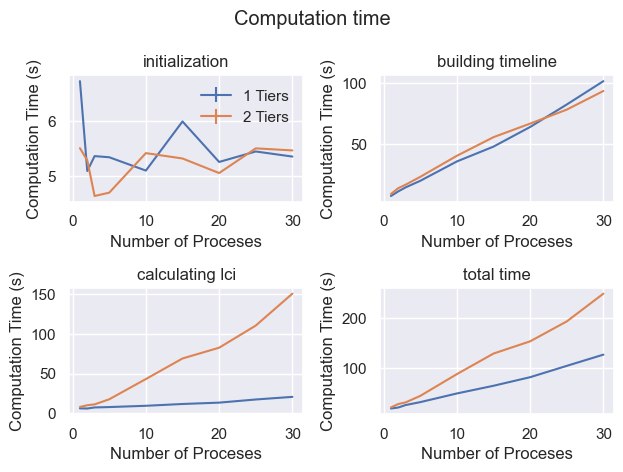

In [68]:
timing_cat_names = ['initialization','building timeline', 'calculating lci', 'total time']
timing_cats = [time_initialize,time_build_timeline, time_lci, time_total]
fig1 = plt.figure()

for i,(cat_name, timing_cat) in enumerate(zip(timing_cat_names, timing_cats)):
   
    ax = fig1.add_subplot(2,2,i+1)
    ax.set_xlabel('Number of Proceses')
    ax.set_ylabel('Computation Time (s)')
    ax.set_title(cat_name)
    for j,n_tier in enumerate(n_tiers[:]):
        ax.errorbar(nr_processes[j,:,:].mean(axis=1), timing_cat[j,:,:].mean(axis=1), yerr=timing_cat[j,:,:].std(axis=1),  label=f'{n_tier} Tiers')
    
    if i == 0:
        ax.legend(frameon=False)   

fig1.suptitle('Computation time')
plt.tight_layout()




## Plot the Total time against the various metrics (nr of processes, exchanges, etc)

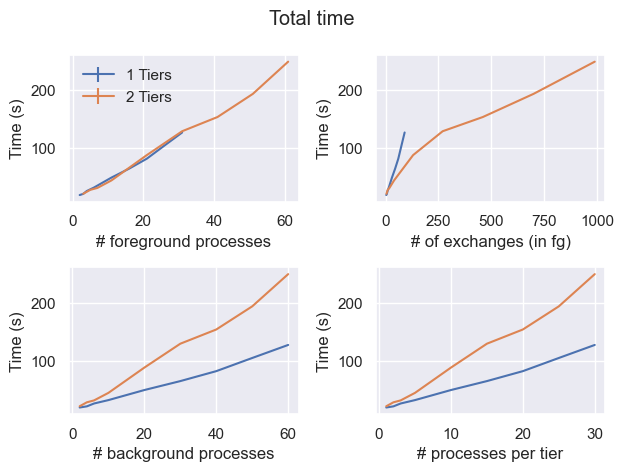

In [69]:
timing_cat_names = ['# foreground processes','# of exchanges (in fg)', '# background processes', '# processes per tier']
timing_cats = [n_foreground, n_exchanges, n_background, nr_processes]

fig2 = plt.figure()

for i,(cat_name,timing_cat) in enumerate(zip(timing_cat_names, timing_cats)):
   
    ax = fig2.add_subplot(2,2,i+1)
    ax.set_xlabel(cat_name)
    ax.set_ylabel('Time (s)')
    # ax.set_title(cat_name)
    for j,n_tier in enumerate(n_tiers[:2]):
        ax.errorbar(timing_cat[j,:,:].mean(axis=1), time_total[j,:,:].mean(axis=1), yerr=time_total[j,:,:].std(axis=1), label=f'{n_tier} Tiers')
    
    if i == 0:
        ax.legend(frameon=False)   

fig2.suptitle('Total time')
plt.tight_layout()




## Plot the time to build the timeline against the various metrics (nr of processes, exchanges, etc)

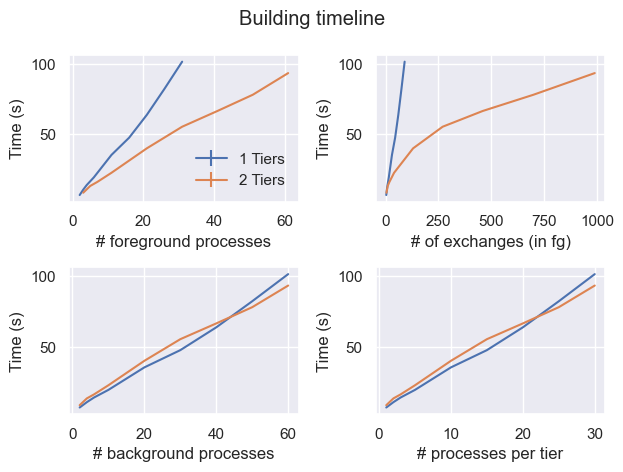

In [70]:


fig3 = plt.figure()

for i,(cat_name,timing_cat) in enumerate(zip(timing_cat_names, timing_cats)):
   
    ax = fig3.add_subplot(2,2,i+1)
    ax.set_xlabel(cat_name)
    ax.set_ylabel('Time (s)')
    # ax.set_title(cat_name)
    for j,n_tier in enumerate(n_tiers[:2]):
        ax.errorbar(timing_cat[j,:,:].mean(axis=1), time_build_timeline[j,:,:].mean(axis=1), yerr=time_build_timeline[j,:,:].std(axis=1), label=f'{n_tier} Tiers')
    
    if i == 0:
        ax.legend(frameon=False)   

fig3.suptitle('Building timeline')
plt.tight_layout()




## Plot the LCI calculation time against the various metrics (nr of processes, exchanges, etc)

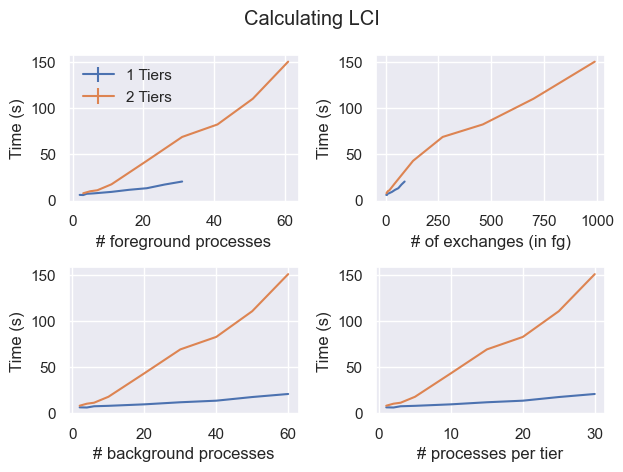

In [71]:

fig4 = plt.figure()

for i,(cat_name,timing_cat) in enumerate(zip(timing_cat_names, timing_cats)):
   
    ax = fig4.add_subplot(2,2,i+1)
    ax.set_xlabel(cat_name)
    ax.set_ylabel('Time (s)')
    # ax.set_title(cat_name)
    for j,n_tier in enumerate(n_tiers[:2]):
        ax.errorbar(timing_cat[j,:,:].mean(axis=1), time_lci[j,:,:].mean(axis=1), yerr=time_lci[j,:,:].std(axis=1), label=f'{n_tier} Tiers')
    
    if i == 0:
        ax.legend(frameon=False)   

fig4.suptitle('Calculating LCI')
plt.tight_layout()




### Results Dell Windows 10 Enterprise

- CPU: 11th Gen Intel(R) Core i5-1145G7 @ 2.60GHz
- Memory: 16GB
- Runs [Pypardiso](https://github.com/haasad/PyPardiso) for linear algebra operations

In [87]:
# Load results from Amelie

load_path = "/Users/ajakobs/Documents/prospective_dynamic_lca/timex_benchmarking_results_arthur/"  # Assuming the save path is the same as the load path

def load_results(load_path):
    loaded_arrays = {}
    for arr_name in arrays_to_save:
        loaded_arrays[arr_name] = np.load(os.path.join(load_path, f"{arr_name}.npy"))
    return loaded_arrays
# Load the results
loaded_results = load_results(load_path)

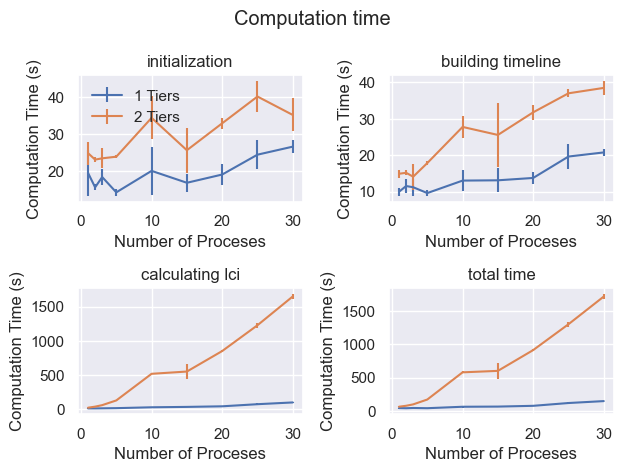

In [62]:
timing_cat_names = ['initialization','building timeline', 'calculating lci', 'total time']
timing_cats = [loaded_results['time_initialize'],loaded_results['time_build_timeline'], loaded_results['time_lci'], loaded_results['time_total']]
fig = plt.figure()

for i,(cat_name, timing_cat) in enumerate(zip(timing_cat_names, timing_cats)):
   
    ax = fig.add_subplot(2,2,i+1)
    ax.set_xlabel('Number of Proceses')
    ax.set_ylabel('Computation Time (s)')
    ax.set_title(cat_name)
    for j,n_tier in enumerate(loaded_results['nr_tiers'][:,0,0]):
        ax.errorbar(loaded_results['nr_processes'][j,:,:].mean(axis=1), timing_cat[j,:,:].mean(axis=1), yerr=timing_cat[j,:,:].std(axis=1),  label=f'{n_tier} Tiers')
    
    if i == 0:
        ax.legend(frameon=False)   

fig.suptitle('Computation time')
plt.tight_layout()




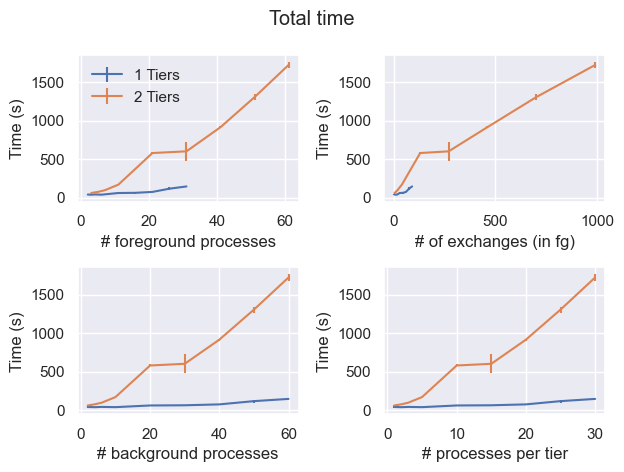

In [63]:
timing_cat_names = ['# foreground processes','# of exchanges (in fg)', '# background processes', '# processes per tier']
timing_cats = [loaded_results['n_foreground'], loaded_results['n_exchanges'],
               loaded_results['n_background'], loaded_results['nr_processes']]

fig = plt.figure()

for i,(cat_name,timing_cat) in enumerate(zip(timing_cat_names, timing_cats)):
   
    ax = fig.add_subplot(2,2,i+1)
    ax.set_xlabel(cat_name)
    ax.set_ylabel('Time (s)')
    # ax.set_title(cat_name)
    for j,n_tier in enumerate(loaded_results['nr_tiers'][:,0,0]):
        ax.errorbar(timing_cat[j,:,:].mean(axis=1), loaded_results['time_total'][j,:,:].mean(axis=1),
                    yerr=loaded_results['time_total'][j,:,:].std(axis=1), label=f'{n_tier} Tiers')
    
    if i == 0:
        ax.legend(frameon=False)   

fig.suptitle('Total time')
plt.tight_layout()



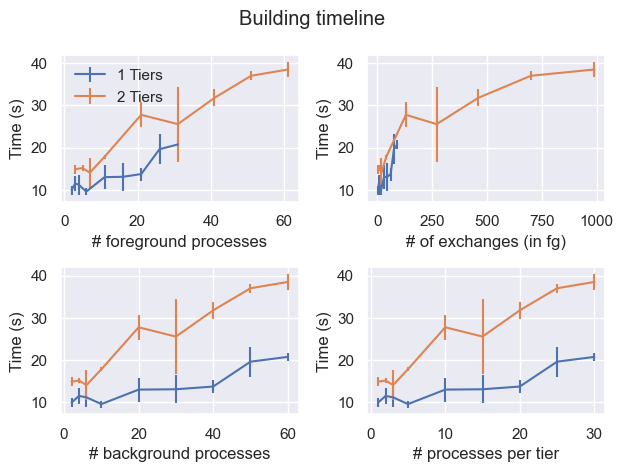

In [64]:
fig = plt.figure()

for i,(cat_name,timing_cat) in enumerate(zip(timing_cat_names, timing_cats)):
   
    ax = fig.add_subplot(2,2,i+1)
    ax.set_xlabel(cat_name)
    ax.set_ylabel('Time (s)')
    # ax.set_title(cat_name)
    for j,n_tier in enumerate(loaded_results['nr_tiers'][:,0,0]):
        ax.errorbar(timing_cat[j,:,:].mean(axis=1), loaded_results['time_build_timeline'][j,:,:].mean(axis=1),
                    yerr=loaded_results['time_build_timeline'][j,:,:].std(axis=1), label=f'{n_tier} Tiers')
    
    if i == 0:
        ax.legend(frameon=False)   

fig.suptitle('Building timeline')
plt.tight_layout()




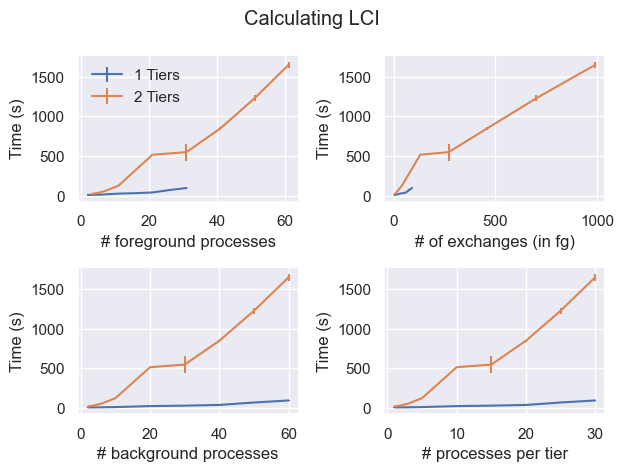

In [65]:
fig = plt.figure()

for i,(cat_name,timing_cat) in enumerate(zip(timing_cat_names, timing_cats)):
   
    ax = fig.add_subplot(2,2,i+1)
    ax.set_xlabel(cat_name)
    ax.set_ylabel('Time (s)')
    # ax.set_title(cat_name)
    for j,n_tier in enumerate(loaded_results['nr_tiers'][:,0,0]):
        ax.errorbar(timing_cat[j,:,:].mean(axis=1), loaded_results['time_lci'][j,:,:].mean(axis=1),
                    yerr=loaded_results['time_lci'][j,:,:].std(axis=1), label=f'{n_tier} Tiers')
    
    if i == 0:
        ax.legend(frameon=False)   

fig.suptitle('Calculating LCI')
plt.tight_layout()




In [88]:
loaded_results['time_total'][1,-2:,:].mean(axis=1)

array([151.40908368, 185.63058551])

In [89]:
loaded_results['time_total'][1,-2:,:].std(axis=1)

array([0.33059281, 0.4702197 ])